## АБ-тест: задача нужен / не нужен 

Эта задача на то, что ты выигрываешь или проигрываешь, если отказываешься от АБ-тестов и просто принимаешь решение об изенениях по среднему. Задание довольно творческое, так как способ симуляции можно придумать разный.

У Аделины и Беллы есть аккаунты на сайте с "топ-контентом" с конверсией $p=0.2\%$. Они меняют вёрстки и смотрят, как дела с деньгами. Белла нанаяла аналитика и принимает решения об изменениях по $p-value < 0.05,$ а Аделина просто смотрит на среднее и катит по нему. Например, если на старом дизайне из тысячи посетителей только $299$ оставило копеечку, а на новом — $300$, берём новый. Если наоборот — оставляем старый.

Пусть у каждой было $100$ правочек. Правочки одинаковые для обеих девушек. На них работает один и тот же фронтендер. Будем считать, что правочки независимы друг от друга. То есть, в какой бы момент мы не выкатили правочку, у нас всегда от неё будет одинаковое воздействие на конверсию. У каждой девушки было $100$ правочек. Кто после сотни правочек вырвется вперёд по конверсии? 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest

plt.style.use('ggplot')
%matplotlib inline

In [2]:
n = 1000
p_adelina, p_bella = 0.2, 0.2

pravki = sts.norm().rvs(100)

conv_adelina = []
conv_bella = []

for i in range(len(pravki)):
    # АДЕЛИНА - просто по среднему
    p_new = p_adelina + pravki[i] / 100
    sample = sts.bernoulli(p_new).rvs(1000)
    if sample.mean() > p_adelina:
        p_adelina = p_new
        conv_adelina.append(p_new)
    else:
        conv_adelina.append(p_adelina)

    # БЕЛЛА - через АБ-тест
    p_new = p_bella + pravki[i] / 100
    sample_control = sts.bernoulli(p_bella).rvs(1000)
    sample_treat = sts.bernoulli(p_new).rvs(1000)
    
    p_control = sample_control.sum()
    p_treat = sample_treat.sum()
    
    pval = proportions_ztest([p_treat, p_control],
                             [1000, 1000],
                             value = 0,
                             alternative = 'larger')[1]
    if pval < 0.05:
        p_bella = p_new
        conv_bella.append(p_new)
    else:
        conv_bella.append(p_bella)
    
print(f"Конверсия Аделины без АБ-теста: {conv_adelina[-1]:.4f}")
print(f"Конверсия Беллы с АБ-тестом: {conv_bella[-1]:.4f}")

Конверсия Аделины без АБ-теста: 0.4249
Конверсия Беллы с АБ-тестом: 0.3078


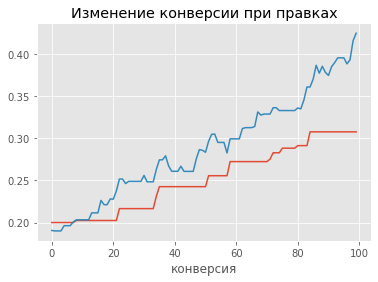

In [3]:
plt.plot(conv_bella)
plt.plot(conv_adelina)
plt.title('Изменение конверсии при правках')
plt.xlabel('правки')
plt.xlabel('конверсия');

*Если распределение правочек - стандартное нормальное, то принимая любую положительную правочку, Аделина вырвется вперед. Но при этом негативные эффекты от правочек она может не заметить, т.к. после правочки случайно могло случится так, что пользователи начали больше донатить (контент стал лучше или сарафанное радио пользователей) и причиной этому не правочка, а что-то иное. Но т.к. эта случайность статистически ей не проверяется, она принимает все подряд.*

*Другими словами, у Аделины гораздо больше шанс допустить ошибку первого рода, т.е. когда она правку оставила, а на самом деле эффект, на который она смотрела, оказался случайным, что равно отвержению нулевой гипотезы, в то время как реальных изменений правочка не приносит. А, например, Белла, если и оставляет правочку, то она точно принесет ей положительный эффект, т.к. она статистически через АБ-тест проверила, что эта правочка рабочая.*

*Сломать логику Аделины можно так:*

In [4]:
n = 1000
p_adelina, p_bella = 0.2, 0.2

pravki = sts.norm(loc=-1).rvs(100)

conv_adelina = []
conv_bella = []

for i in range(len(pravki)):
    # АДЕЛИНА - просто по среднему
    p_new = p_adelina + pravki[i] / 100
    sample = sts.bernoulli(p_new).rvs(1000)
    if sample.mean() > p_adelina:
        p_adelina = p_new
        conv_adelina.append(p_new)
    else:
        conv_adelina.append(p_adelina)

    # БЕЛЛА - через АБ-тест
    p_new = p_bella + pravki[i] / 100
    sample_control = sts.bernoulli(p_bella).rvs(1000)
    sample_treat = sts.bernoulli(p_new).rvs(1000)
    
    p_control = sample_control.sum()
    p_treat = sample_treat.sum()
    
    pval = proportions_ztest([p_treat, p_control],
                             [1000, 1000],
                             value = 0,
                             alternative = 'larger')[1]
    if pval < 0.05:
        p_bella = p_new
        conv_bella.append(p_new)
    else:
        conv_bella.append(p_bella)
    
print(f"Конверсия Аделины без АБ-теста: {conv_adelina[-1]:.4f}")
print(f"Конверсия Беллы с АБ-тестом: {conv_bella[-1]:.4f}")

Конверсия Аделины без АБ-теста: 0.1313
Конверсия Беллы с АБ-тестом: 0.2029


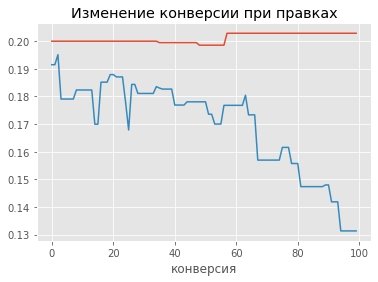

In [5]:
plt.plot(conv_bella)
plt.plot(conv_adelina)
plt.title('Изменение конверсии при правках')
plt.xlabel('правки')
plt.xlabel('конверсия');

*Если правочки будут распределены по-другому - например, со нормально со средним -1 (такое может быть, если страница актрисы с новой правочкой становится слишком яркой, аляпистой, отвлекающей от сути дела) - то Аделина может опять же поймать случайный эффект от правочки и подумать, что она ей нужна, хотя она вносит негативный эффект в конверсию*

*Белла же очень осторожна в своих решениях и берет только те правочки, которые вносят положительный вклад, проверяя через АБ-тест этот положительный эффект*

*Итог такой: все зависит от того, как распределены эти правочки и как работает это на онлифансе. Могу предложить 2 варианта развития бизнеса актрис, которые требуют изучения работы рынка. Если нам без разницы на аккуратное, выдержанное содержание страницы и чем больше правочек на страничке, тем лучше, то и без АБ-тестов можно в целом обойтись. Если же страница должна быть выдержана, user-friendly и правочка работает на актрису не всегда, то можно смело нанимать аналитика, на которого в таком бизнесе думаю деньги есть!*